In [1]:
import numpy as np
import pandas as pd
from torch import nn
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
from tqdm import tqdm

/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
def early_prediction_score(y_true, y_pred, alpha=0.5):
    errors = y_pred - y_true
    # Heavier penalty for late predictions
    weights = np.where(errors < 0, alpha, 1)
    return np.mean(weights * errors**2)

In [ ]:
TRAIN_BEARINGS = {
    1: [
        '1_1',
        '1_2',
    ],
    2: [
        '2_1',
        '2_2',
    ],
    3: [
        '3_1',
        '3_2',
    ]
}

TEST_BEARINGS = {
    1: [
        '1_3',
        '1_4',
        '1_5',
        '1_6',
        '1_7',
    ],
    2: [
        '2_3',
        '2_4',
        '2_5',
        '2_6',
        '2_7',
    ],
    3: [
        '3_3',
    ]
}

In [4]:
dataset = datasets.Dataset('PRONOSTIA')
tasks = dataset['rul']
df = tasks.load()

Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for prognosis and health management datasets." SoftwareX 29 (2025): 102039.



Reading Bearing3_3: 100%|██████████| 13959/13959 [00:32<00:00, 434.43it/s]
INFO:root:Read in 52.4766411781311 seconds


In [5]:
# train
df[0]['unit'].unique()

array(['1_1', '1_2', '2_1', '2_2', '3_1', '3_2'], dtype=object)

In [6]:
df[0].head(5)

,V_acc,rul,unit,H_acc
0,-0.146,28029,1_1,0.552
1,-0.480,28029,1_1,0.501
2,0.435,28029,1_1,0.138
3,0.240,28029,1_1,-0.423
4,0.020,28029,1_1,-0.802


In [7]:
# test
df[1]['unit'].unique()

array(['1_3', '1_4', '1_5', '1_6', '1_7', '2_3', '2_4', '2_5', '2_6',
       '2_7', '3_3'], dtype=object)

In [8]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]['unit']

0          1_1
1          1_1
2          1_1
3          1_1
4          1_1
          ... 
7175675    1_1
7175676    1_1
7175677    1_1
7175678    1_1
7175679    1_1
Name: unit, Length: 7175680, dtype: object

In [9]:
df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])]

,V_acc,rul,unit,H_acc
0,-0.146,28029,1_1,0.552
1,-0.480,28029,1_1,0.501
2,0.435,28029,1_1,0.138
3,0.240,28029,1_1,-0.423
4,0.020,28029,1_1,-0.802
...,...,...,...,...
7175675,2.129,0,1_1,-3.353
7175676,-2.299,0,1_1,-2.868
7175677,-1.844,0,1_1,-5.507
7175678,2.146,0,1_1,-3.578


In [10]:
df[1][df[1]['unit'].isin(TEST_BEARINGS[1])]

,V_acc,rul,unit,H_acc
0,0.044,23749,1_3,0.092
1,0.432,23749,1_3,-0.025
2,0.008,23749,1_3,-0.104
3,-0.264,23749,1_3,0.056
4,-0.195,23749,1_3,0.074
...,...,...,...,...
3845115,-0.013,7570,1_7,0.481
3845116,-0.272,7570,1_7,0.191
3845117,0.466,7570,1_7,0.250
3845118,-0.582,7570,1_7,0.001


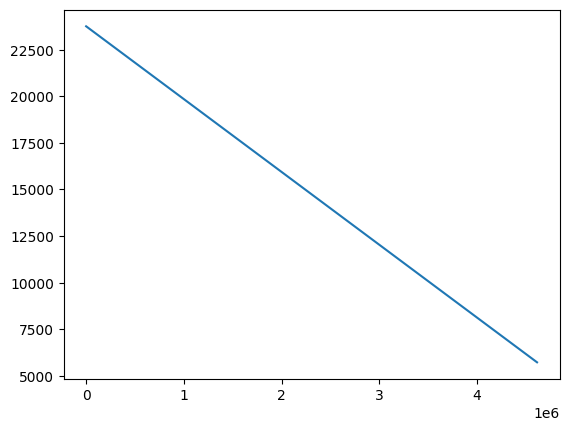

In [11]:
plt.plot(df[1][df[1]['unit'] == '1_3']['rul'])

In [12]:
# sns.kdeplot(df[0][df[0]['unit'] == '1_1']['H_acc'], label='Train')
# sns.kdeplot(test_features['h_RMS'], label='Test')
# plt.legend(); plt.show()

In [41]:
class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, df, window_size=2560, step=2560 // 2):
        self.windows = []
        self.ruls = []
        
        # vib_h = df['H_acc'].values
        # vib_v = df['V_acc'].values
        # rul = df['rul'].values
        rul = df.groupby('unit')['rul'].transform(
            lambda x: x / x.max()
            # lambda x: x
        ).values
        # max_rul = max(rul)
        
        # Normalize per bearing
        # vib_h = (vib_h - vib_h.mean()) / (vib_h.std() + 1e-8)
        # vib_v = (vib_v - vib_v.mean()) / (vib_v.std() + 1e-8)

        vib_h = df.groupby('unit')['H_acc'].transform(
        lambda x: (x - x.mean()) / (x.std() + 1e-8)
    )
        vib_v = df.groupby('unit')['V_acc'].transform(
            lambda x: (x - x.mean()) / (x.std() + 1e-8)
        )
        
        # Create sequences
        for i in range(0, len(df) - window_size, step):
            self.windows.append(np.stack([vib_h[i:i+window_size], 
                                        vib_v[i:i+window_size]], axis=1))
            self.ruls.append(rul[i+window_size])

    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.windows[idx]), torch.FloatTensor([self.ruls[idx]])
    
train_dataset = BearingDataset(
    df=df[0][df[0]['unit'].isin(TRAIN_BEARINGS[1])],
)

test_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_7'],
)

val_dataset = BearingDataset(
    df=df[1][df[1]['unit'] == '1_4'],
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [14]:
train_dataset[0][1].shape

torch.Size([1])

In [18]:
class BearingCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Feature extractor
        self.features = torch.nn.Sequential(
            # Layer 1: Wide receptive field
            torch.nn.Conv1d(2, 64, kernel_size=51, padding=25),  # (B, 2, 2560) -> (B, 64, 2560)
            torch.nn.BatchNorm1d(64),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 64, 1278)
            
            # Layer 2: Mid-range features
            torch.nn.Conv1d(64, 128, kernel_size=25, padding=12),  # -> (B, 128, 1278)
            torch.nn.BatchNorm1d(128),
            torch.nn.LeakyReLU(0.1),
            torch.nn.MaxPool1d(4, stride=2),  # -> (B, 128, 637)
            
            # Layer 3: Local features
            torch.nn.Conv1d(128, 256, kernel_size=10, padding=5),  # -> (B, 256, 637)
            torch.nn.BatchNorm1d(256),
            torch.nn.LeakyReLU(0.1),
            torch.nn.AdaptiveAvgPool1d(1)  # -> (B, 256, 1)
        )
        
        # Regressor (fixed input dim)
        self.regressor = torch.nn.Sequential(
            torch.nn.Linear(256, 128),
            torch.nn.LayerNorm(128),  # Better for regression
            torch.nn.LeakyReLU(0.1),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(128, 1)
            # Removed Sigmoid() for regression
        )
    
    def forward(self, x):
        # Input: (B, 2560, 2)
        x = x.permute(0, 2, 1)  # -> (B, 2, 2560)
        x = self.features(x)     # -> (B, 256, 1)
        x = x.squeeze(-1)        # -> (B, 256)
        return self.regressor(x).squeeze()  # -> (B,)

model = BearingCNN()

print(model)

BearingCNN(
  (features): Sequential(
    (0): Conv1d(2, 64, kernel_size=(51,), stride=(1,), padding=(25,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 128, kernel_size=(25,), stride=(1,), padding=(12,))
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool1d(kernel_size=4, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(128, 256, kernel_size=(10,), stride=(1,), padding=(5,))
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): AdaptiveAvgPool1d(output_size=1)
  )
  (regressor): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs,
):
    train_r2 = []
    train_mae = []
    train_mse = []
    train_rmse = []
    train_loss = []

    val_r2 = []
    val_mae = []
    val_mse = []
    val_rmse = []
    val_loss = []

    for epoch in range(epochs):
        model.train()

        epoch_train_loss = 0
        epoch_train_preds = []
        epoch_train_targets = []

        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            y_pred = model(X_batch).flatten()

            epoch_train_preds.append(y_pred)
            epoch_train_targets.append(y_batch)

            loss = criterion(y_pred, y_batch)

            # if y_pred.size(0) > 1:
            #     sorted_pred, _ = torch.sort(y_pred.squeeze(), descending=True)
            #     mono_loss = torch.relu(sorted_pred[1:] - sorted_pred[:-1]).mean()
            #     loss += 0.1 * mono_loss
            
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) 
            optimizer.step()
            
            epoch_train_loss += loss.item()
        
        train_preds = torch.cat(epoch_train_preds).cpu().detach().numpy()
        train_targets = torch.cat(epoch_train_targets).cpu().detach().numpy()
        
        epoch_train_r2 = r2_score(train_targets, train_preds)
        epoch_train_mae = mean_absolute_error(train_targets, train_preds)
        epoch_train_mse = mean_squared_error(train_targets, train_preds)
        epoch_train_rmse = np.sqrt(epoch_train_mse)
        # epoch_train_eps = early_prediction_score(train_targets, train_preds)
        epoch_train_loss = epoch_train_loss/len(train_loader)
        
        train_r2.append(epoch_train_r2)
        train_mae.append(epoch_train_mae)
        train_mse.append(epoch_train_mse)
        train_rmse.append(epoch_train_rmse)
        # train_eps.append(epoch_train_eps)
        train_loss.append(epoch_train_loss)
    
        print(
            f'Epoch {epoch + 1}: Train Loss {epoch_train_loss:.4f}, '
                + f'Train R2 = {epoch_train_r2:.3f}, '
                + f'Train RMSE = {epoch_train_rmse:.3f}, '
                + f'Train MSE = {epoch_train_mse:.3f}, '
                + f'Train MAE = {epoch_train_mae:.3f}'
                # + f'Train EPS = {epoch_train_eps:.3f}'
        )


        model.eval()

        epoch_val_loss = 0
        epoch_val_preds = []
        epoch_val_targets = []

        with torch.no_grad():
            for X_val, y_val in tqdm(val_loader, desc=f'Epoch {epoch + 1} Val'):
                X_val, y_val = X_val.to(device), y_val.to(device)

                y_pred = model(X_val).flatten()

                epoch_val_preds.append(y_pred)
                epoch_val_targets.append(y_val)
                
                epoch_val_loss += criterion(y_pred, y_val).item()

        val_preds = torch.cat(epoch_val_preds).cpu().detach().numpy()
        val_targets = torch.cat(epoch_val_targets).cpu().detach().numpy()
        
        epoch_val_r2 = r2_score(val_targets, val_preds)
        epoch_val_mae = mean_absolute_error(val_targets, val_preds)
        epoch_val_mse = mean_squared_error(val_targets, val_preds)
        epoch_val_rmse = np.sqrt(epoch_val_mse)
        epoch_val_loss = epoch_val_loss/len(val_loader)
        # scheduler.step(epoch_val_loss)
        
        val_r2.append(epoch_val_r2)
        val_mae.append(epoch_val_mae)
        val_mse.append(epoch_val_mse)
        val_rmse.append(epoch_val_rmse)
        val_loss.append(epoch_val_loss)

        print(
            f'Epoch {epoch + 1}: Val Loss {epoch_val_loss:.4f}, '
                + f'Val R2 = {epoch_val_r2:.3f}, '
                + f'Val RMSE = {epoch_val_rmse:.3f}, '
                + f'Val MSE = {epoch_val_mse:.3f}, '
                + f'Val MAE = {epoch_val_mae:.3f}'
        ) 

    return {
        'train_loss': train_loss,
        'train_r2': train_r2,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'val_loss': val_loss,
        'val_r2': val_r2,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_rmse': val_rmse,
    }

In [ ]:
train_results = train(model, train_loader, val_loader, optimizer, criterion, device, 50)

train_results

  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 47.83it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 47.62it/s]


Epoch 1: Train Loss 0.0371, Train R2 = 0.552, Train RMSE = 0.193, Train MSE = 0.037, Train MAE = 0.107


Epoch 1 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1 Val:  82%|████████▏ | 59/72 [00:00<00:00, 191.31it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1 Val: 100%|██████████| 72/72 [00:00<00:00, 191.55it/s]


Epoch 1: Val Loss 0.3798, Val R2 = -3.901, Val RMSE = 0.620, Val MSE = 0.385, Val MAE = 0.551


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 48.03it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 48.14it/s]


Epoch 2: Train Loss 0.0332, Train R2 = 0.600, Train RMSE = 0.183, Train MSE = 0.033, Train MAE = 0.098


Epoch 2 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 2 Val:  79%|███████▉  | 57/72 [00:00<00:00, 187.59it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 2 Val: 100%|██████████| 72/72 [00:00<00:00, 189.12it/s]


Epoch 2: Val Loss 0.3279, Val R2 = -3.231, Val RMSE = 0.576, Val MSE = 0.332, Val MAE = 0.503


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 47.50it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 47.72it/s]


Epoch 3: Train Loss 0.0375, Train R2 = 0.547, Train RMSE = 0.194, Train MSE = 0.038, Train MAE = 0.104


Epoch 3 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 3 Val:  81%|████████  | 58/72 [00:00<00:00, 189.05it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 3 Val: 100%|██████████| 72/72 [00:00<00:00, 189.26it/s]


Epoch 3: Val Loss 0.3608, Val R2 = -3.655, Val RMSE = 0.604, Val MSE = 0.365, Val MAE = 0.535


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 47.58it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 47.61it/s]


Epoch 4: Train Loss 0.0402, Train R2 = 0.515, Train RMSE = 0.201, Train MSE = 0.040, Train MAE = 0.107


Epoch 4 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 4 Val:  82%|████████▏ | 59/72 [00:00<00:00, 190.75it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 4 Val: 100%|██████████| 72/72 [00:00<00:00, 191.82it/s]


Epoch 4: Val Loss 0.3501, Val R2 = -3.518, Val RMSE = 0.595, Val MSE = 0.354, Val MAE = 0.524


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 46.97it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 47.20it/s]


Epoch 5: Train Loss 0.0426, Train R2 = 0.486, Train RMSE = 0.207, Train MSE = 0.043, Train MAE = 0.114


Epoch 5 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 5 Val:  79%|███████▉  | 57/72 [00:00<00:00, 186.88it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 5 Val: 100%|██████████| 72/72 [00:00<00:00, 188.03it/s]


Epoch 5: Val Loss 0.3840, Val R2 = -3.954, Val RMSE = 0.623, Val MSE = 0.389, Val MAE = 0.555


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 46.40it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 46.57it/s]


Epoch 6: Train Loss 0.0431, Train R2 = 0.481, Train RMSE = 0.208, Train MSE = 0.043, Train MAE = 0.114


Epoch 6 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 6 Val:  79%|███████▉  | 57/72 [00:00<00:00, 185.90it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 6 Val: 100%|██████████| 72/72 [00:00<00:00, 187.00it/s]


Epoch 6: Val Loss 0.3644, Val R2 = -3.701, Val RMSE = 0.607, Val MSE = 0.369, Val MAE = 0.538


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:03<00:00, 44.06it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:03<00:00, 44.73it/s]


Epoch 7: Train Loss 0.0435, Train R2 = 0.475, Train RMSE = 0.209, Train MSE = 0.044, Train MAE = 0.114


Epoch 7 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 7 Val:  79%|███████▉  | 57/72 [00:00<00:00, 184.14it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 7 Val: 100%|██████████| 72/72 [00:00<00:00, 185.62it/s]


Epoch 7: Val Loss 0.3312, Val R2 = -3.273, Val RMSE = 0.579, Val MSE = 0.335, Val MAE = 0.506


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:04<00:00, 42.78it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 42.98it/s]


Epoch 8: Train Loss 0.0438, Train R2 = 0.472, Train RMSE = 0.210, Train MSE = 0.044, Train MAE = 0.115


Epoch 8 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 8 Val:  75%|███████▌  | 54/72 [00:00<00:00, 176.42it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 8 Val: 100%|██████████| 72/72 [00:00<00:00, 176.97it/s]


Epoch 8: Val Loss 0.3205, Val R2 = -3.135, Val RMSE = 0.570, Val MSE = 0.324, Val MAE = 0.495


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 40.91it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 40.88it/s]


Epoch 9: Train Loss 0.0454, Train R2 = 0.453, Train RMSE = 0.213, Train MSE = 0.046, Train MAE = 0.118


Epoch 9 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 9 Val:  78%|███████▊  | 56/72 [00:00<00:00, 178.87it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 9 Val: 100%|██████████| 72/72 [00:00<00:00, 179.48it/s]


Epoch 9: Val Loss 0.3473, Val R2 = -3.481, Val RMSE = 0.593, Val MSE = 0.352, Val MAE = 0.521


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:04<00:00, 38.52it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 39.83it/s]


Epoch 10: Train Loss 0.0488, Train R2 = 0.411, Train RMSE = 0.221, Train MSE = 0.049, Train MAE = 0.123


Epoch 10 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 10 Val:  93%|█████████▎| 67/72 [00:00<00:00, 163.93it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 10 Val: 100%|██████████| 72/72 [00:00<00:00, 164.41it/s]


Epoch 10: Val Loss 0.2891, Val R2 = -2.729, Val RMSE = 0.541, Val MSE = 0.293, Val MAE = 0.462


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.68it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.69it/s]


Epoch 11: Train Loss 0.0496, Train R2 = 0.401, Train RMSE = 0.223, Train MSE = 0.050, Train MAE = 0.129


Epoch 11 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 11 Val:  89%|████████▉ | 64/72 [00:00<00:00, 154.88it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 11 Val: 100%|██████████| 72/72 [00:00<00:00, 155.04it/s]


Epoch 11: Val Loss 0.3088, Val R2 = -2.983, Val RMSE = 0.559, Val MSE = 0.313, Val MAE = 0.484


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.52it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.58it/s]


Epoch 12: Train Loss 0.0520, Train R2 = 0.373, Train RMSE = 0.229, Train MSE = 0.052, Train MAE = 0.134


Epoch 12 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 12 Val:  89%|████████▉ | 64/72 [00:00<00:00, 154.81it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 12 Val: 100%|██████████| 72/72 [00:00<00:00, 155.70it/s]


Epoch 12: Val Loss 0.3151, Val R2 = -3.065, Val RMSE = 0.565, Val MSE = 0.319, Val MAE = 0.489


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.41it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.58it/s]


Epoch 13: Train Loss 0.0522, Train R2 = 0.371, Train RMSE = 0.229, Train MSE = 0.052, Train MAE = 0.134


Epoch 13 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 13 Val:  89%|████████▉ | 64/72 [00:00<00:00, 154.21it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 13 Val: 100%|██████████| 72/72 [00:00<00:00, 154.13it/s]


Epoch 13: Val Loss 0.3045, Val R2 = -2.927, Val RMSE = 0.555, Val MSE = 0.308, Val MAE = 0.481


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.48it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.47it/s]


Epoch 14: Train Loss 0.0563, Train R2 = 0.322, Train RMSE = 0.238, Train MSE = 0.056, Train MAE = 0.143


Epoch 14 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 14 Val:  89%|████████▉ | 64/72 [00:00<00:00, 155.09it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 14 Val: 100%|██████████| 72/72 [00:00<00:00, 155.88it/s]


Epoch 14: Val Loss 0.2692, Val R2 = -2.472, Val RMSE = 0.522, Val MSE = 0.272, Val MAE = 0.443


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 38.18it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 38.23it/s]


Epoch 15: Train Loss 0.0580, Train R2 = 0.300, Train RMSE = 0.241, Train MSE = 0.058, Train MAE = 0.145


Epoch 15 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 15 Val:  89%|████████▉ | 64/72 [00:00<00:00, 154.97it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 15 Val: 100%|██████████| 72/72 [00:00<00:00, 156.19it/s]


Epoch 15: Val Loss 0.3496, Val R2 = -3.509, Val RMSE = 0.595, Val MSE = 0.354, Val MAE = 0.524


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 37.20it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 37.42it/s]


Epoch 16: Train Loss 0.0406, Train R2 = 0.511, Train RMSE = 0.202, Train MSE = 0.041, Train MAE = 0.124


Epoch 16 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 16 Val:  89%|████████▉ | 64/72 [00:00<00:00, 153.08it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 16 Val: 100%|██████████| 72/72 [00:00<00:00, 154.26it/s]


Epoch 16: Val Loss 0.3387, Val R2 = -3.368, Val RMSE = 0.585, Val MSE = 0.343, Val MAE = 0.514


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 34.85it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:04<00:00, 35.66it/s]


Epoch 17: Train Loss 0.0555, Train R2 = 0.331, Train RMSE = 0.236, Train MSE = 0.056, Train MAE = 0.149


Epoch 17 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 17 Val:  83%|████████▎ | 60/72 [00:00<00:00, 147.14it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 17 Val: 100%|██████████| 72/72 [00:00<00:00, 147.67it/s]


Epoch 17: Val Loss 0.2445, Val R2 = -2.152, Val RMSE = 0.497, Val MSE = 0.247, Val MAE = 0.418


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:04<00:00, 34.68it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 34.82it/s]


Epoch 18: Train Loss 0.0641, Train R2 = 0.227, Train RMSE = 0.254, Train MSE = 0.064, Train MAE = 0.153


Epoch 18 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 18 Val:  86%|████████▌ | 62/72 [00:00<00:00, 150.31it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 18 Val: 100%|██████████| 72/72 [00:00<00:00, 151.24it/s]


Epoch 18: Val Loss 0.1551, Val R2 = -0.999, Val RMSE = 0.396, Val MSE = 0.157, Val MAE = 0.321


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 33.50it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 34.09it/s]


Epoch 19: Train Loss 0.0382, Train R2 = 0.541, Train RMSE = 0.196, Train MSE = 0.038, Train MAE = 0.130


Epoch 19 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 19 Val:  83%|████████▎ | 60/72 [00:00<00:00, 147.59it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 19 Val: 100%|██████████| 72/72 [00:00<00:00, 148.62it/s]


Epoch 19: Val Loss 0.2067, Val R2 = -1.663, Val RMSE = 0.457, Val MSE = 0.209, Val MAE = 0.378


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 31.08it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 33.19it/s]


Epoch 20: Train Loss 0.0704, Train R2 = 0.150, Train RMSE = 0.266, Train MSE = 0.071, Train MAE = 0.167


Epoch 20 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 20 Val:  82%|████████▏ | 59/72 [00:00<00:00, 142.97it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 20 Val: 100%|██████████| 72/72 [00:00<00:00, 143.91it/s]


Epoch 20: Val Loss 0.2595, Val R2 = -2.347, Val RMSE = 0.512, Val MSE = 0.263, Val MAE = 0.436


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 32.06it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 32.10it/s]


Epoch 21: Train Loss 0.0583, Train R2 = 0.297, Train RMSE = 0.242, Train MSE = 0.059, Train MAE = 0.149


Epoch 21 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 21 Val:  82%|████████▏ | 59/72 [00:00<00:00, 143.57it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 21 Val: 100%|██████████| 72/72 [00:00<00:00, 143.86it/s]


Epoch 21: Val Loss 0.2705, Val R2 = -2.489, Val RMSE = 0.523, Val MSE = 0.274, Val MAE = 0.446


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 30.19it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 30.84it/s]


Epoch 22: Train Loss 0.0520, Train R2 = 0.374, Train RMSE = 0.228, Train MSE = 0.052, Train MAE = 0.142


Epoch 22 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 22 Val:  97%|█████████▋| 70/72 [00:00<00:00, 134.47it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 22 Val: 100%|██████████| 72/72 [00:00<00:00, 134.92it/s]


Epoch 22: Val Loss 0.2305, Val R2 = -1.973, Val RMSE = 0.483, Val MSE = 0.233, Val MAE = 0.403


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:05<00:00, 30.00it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 30.01it/s]


Epoch 23: Train Loss 0.0414, Train R2 = 0.501, Train RMSE = 0.204, Train MSE = 0.042, Train MAE = 0.121


Epoch 23 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 23 Val:  96%|█████████▌| 69/72 [00:00<00:00, 136.14it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 23 Val: 100%|██████████| 72/72 [00:00<00:00, 135.81it/s]


Epoch 23: Val Loss 0.3463, Val R2 = -3.466, Val RMSE = 0.592, Val MSE = 0.350, Val MAE = 0.532


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:05<00:00, 29.95it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 30.10it/s]


Epoch 24: Train Loss 0.0261, Train R2 = 0.686, Train RMSE = 0.162, Train MSE = 0.026, Train MAE = 0.099


Epoch 24 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 24 Val:  97%|█████████▋| 70/72 [00:00<00:00, 135.31it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 24 Val: 100%|██████████| 72/72 [00:00<00:00, 136.17it/s]


Epoch 24: Val Loss 0.2131, Val R2 = -1.748, Val RMSE = 0.464, Val MSE = 0.216, Val MAE = 0.409


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:05<00:00, 29.79it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 30.04it/s]


Epoch 25: Train Loss 0.0299, Train R2 = 0.639, Train RMSE = 0.173, Train MSE = 0.030, Train MAE = 0.109


Epoch 25 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 25 Val:  96%|█████████▌| 69/72 [00:00<00:00, 131.84it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 25 Val: 100%|██████████| 72/72 [00:00<00:00, 132.24it/s]


Epoch 25: Val Loss 0.1895, Val R2 = -1.443, Val RMSE = 0.438, Val MSE = 0.192, Val MAE = 0.378


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 172/176 [00:05<00:00, 29.57it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:05<00:00, 29.99it/s]


Epoch 26: Train Loss 0.0381, Train R2 = 0.540, Train RMSE = 0.196, Train MSE = 0.038, Train MAE = 0.116


Epoch 26 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 26 Val:  97%|█████████▋| 70/72 [00:00<00:00, 133.14it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 26 Val: 100%|██████████| 72/72 [00:00<00:00, 133.06it/s]


Epoch 26: Val Loss 0.3151, Val R2 = -3.064, Val RMSE = 0.565, Val MSE = 0.319, Val MAE = 0.494


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 28.16it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 28.58it/s]


Epoch 27: Train Loss 0.0283, Train R2 = 0.660, Train RMSE = 0.168, Train MSE = 0.028, Train MAE = 0.100


Epoch 27 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 27 Val:  90%|█████████ | 65/72 [00:00<00:00, 126.66it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 27 Val: 100%|██████████| 72/72 [00:00<00:00, 127.05it/s]


Epoch 27: Val Loss 0.2384, Val R2 = -2.074, Val RMSE = 0.491, Val MSE = 0.241, Val MAE = 0.427


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 27.93it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 28.20it/s]


Epoch 28: Train Loss 0.0204, Train R2 = 0.755, Train RMSE = 0.143, Train MSE = 0.020, Train MAE = 0.093


Epoch 28 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 28 Val:  92%|█████████▏| 66/72 [00:00<00:00, 126.75it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 28 Val: 100%|██████████| 72/72 [00:00<00:00, 127.44it/s]


Epoch 28: Val Loss 0.1978, Val R2 = -1.550, Val RMSE = 0.447, Val MSE = 0.200, Val MAE = 0.379


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 27.79it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 28.09it/s]


Epoch 29: Train Loss 0.0402, Train R2 = 0.516, Train RMSE = 0.201, Train MSE = 0.040, Train MAE = 0.116


Epoch 29 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 29 Val:  93%|█████████▎| 67/72 [00:00<00:00, 128.89it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 29 Val: 100%|██████████| 72/72 [00:00<00:00, 129.28it/s]


Epoch 29: Val Loss 0.2600, Val R2 = -2.352, Val RMSE = 0.513, Val MSE = 0.263, Val MAE = 0.463


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 28.22it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 28.20it/s]


Epoch 30: Train Loss 0.0302, Train R2 = 0.636, Train RMSE = 0.174, Train MSE = 0.030, Train MAE = 0.097


Epoch 30 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 30 Val:  92%|█████████▏| 66/72 [00:00<00:00, 125.69it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 30 Val: 100%|██████████| 72/72 [00:00<00:00, 127.15it/s]


Epoch 30: Val Loss 0.2836, Val R2 = -2.657, Val RMSE = 0.536, Val MSE = 0.287, Val MAE = 0.495


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 27.96it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 28.11it/s]


Epoch 31: Train Loss 0.0153, Train R2 = 0.816, Train RMSE = 0.124, Train MSE = 0.015, Train MAE = 0.079


Epoch 31 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 31 Val:  89%|████████▉ | 64/72 [00:00<00:00, 128.10it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 31 Val: 100%|██████████| 72/72 [00:00<00:00, 128.26it/s]


Epoch 31: Val Loss 0.0915, Val R2 = -0.179, Val RMSE = 0.304, Val MSE = 0.093, Val MAE = 0.252


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 27.74it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 28.06it/s]


Epoch 32: Train Loss 0.0280, Train R2 = 0.662, Train RMSE = 0.168, Train MSE = 0.028, Train MAE = 0.094


Epoch 32 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 32 Val:  92%|█████████▏| 66/72 [00:00<00:00, 127.07it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 32 Val: 100%|██████████| 72/72 [00:00<00:00, 127.27it/s]


Epoch 32: Val Loss 0.4936, Val R2 = -5.368, Val RMSE = 0.707, Val MSE = 0.500, Val MAE = 0.673


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 25.06it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 27.17it/s]


Epoch 33: Train Loss 0.0154, Train R2 = 0.815, Train RMSE = 0.124, Train MSE = 0.015, Train MAE = 0.079


Epoch 33 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 33 Val:  85%|████████▍ | 61/72 [00:00<00:00, 119.81it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 33 Val: 100%|██████████| 72/72 [00:00<00:00, 120.07it/s]


Epoch 33: Val Loss 0.0692, Val R2 = 0.107, Val RMSE = 0.265, Val MSE = 0.070, Val MAE = 0.227


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 25.24it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 25.80it/s]


Epoch 34: Train Loss 0.0179, Train R2 = 0.784, Train RMSE = 0.134, Train MSE = 0.018, Train MAE = 0.083


Epoch 34 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 34 Val:  89%|████████▉ | 64/72 [00:00<00:00, 122.62it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 34 Val: 100%|██████████| 72/72 [00:00<00:00, 122.13it/s]


Epoch 34: Val Loss 0.2012, Val R2 = -1.594, Val RMSE = 0.451, Val MSE = 0.204, Val MAE = 0.390


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 25.19it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 25.66it/s]


Epoch 35: Train Loss 0.0234, Train R2 = 0.718, Train RMSE = 0.153, Train MSE = 0.024, Train MAE = 0.092


Epoch 35 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 35 Val:  90%|█████████ | 65/72 [00:00<00:00, 121.26it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 35 Val: 100%|██████████| 72/72 [00:00<00:00, 121.70it/s]


Epoch 35: Val Loss 0.0795, Val R2 = -0.018, Val RMSE = 0.283, Val MSE = 0.080, Val MAE = 0.242


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 25.30it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 25.67it/s]


Epoch 36: Train Loss 0.0167, Train R2 = 0.798, Train RMSE = 0.130, Train MSE = 0.017, Train MAE = 0.080


Epoch 36 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 36 Val:  89%|████████▉ | 64/72 [00:00<00:00, 122.26it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 36 Val: 100%|██████████| 72/72 [00:00<00:00, 122.91it/s]


Epoch 36: Val Loss 0.0753, Val R2 = 0.042, Val RMSE = 0.274, Val MSE = 0.075, Val MAE = 0.239


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 25.48it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 25.52it/s]


Epoch 37: Train Loss 0.0162, Train R2 = 0.806, Train RMSE = 0.127, Train MSE = 0.016, Train MAE = 0.076


Epoch 37 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 37 Val:  88%|████████▊ | 63/72 [00:00<00:00, 124.31it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 37 Val: 100%|██████████| 72/72 [00:00<00:00, 123.64it/s]


Epoch 37: Val Loss 0.0769, Val R2 = 0.039, Val RMSE = 0.275, Val MSE = 0.075, Val MAE = 0.238


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 25.45it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 25.52it/s]


Epoch 38: Train Loss 0.0119, Train R2 = 0.858, Train RMSE = 0.109, Train MSE = 0.012, Train MAE = 0.075


Epoch 38 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 38 Val:  90%|█████████ | 65/72 [00:00<00:00, 124.31it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 38 Val: 100%|██████████| 72/72 [00:00<00:00, 124.55it/s]


Epoch 38: Val Loss 0.1361, Val R2 = -0.752, Val RMSE = 0.371, Val MSE = 0.137, Val MAE = 0.306


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 25.47it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 25.37it/s]


Epoch 39: Train Loss 0.0319, Train R2 = 0.616, Train RMSE = 0.179, Train MSE = 0.032, Train MAE = 0.099


Epoch 39 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 39 Val:  89%|████████▉ | 64/72 [00:00<00:00, 122.79it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 39 Val: 100%|██████████| 72/72 [00:00<00:00, 122.90it/s]


Epoch 39: Val Loss 0.1208, Val R2 = -0.548, Val RMSE = 0.348, Val MSE = 0.121, Val MAE = 0.288


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:07<00:00, 24.74it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 24.93it/s]


Epoch 40: Train Loss 0.0265, Train R2 = 0.681, Train RMSE = 0.163, Train MSE = 0.027, Train MAE = 0.094


Epoch 40 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 40 Val:  86%|████████▌ | 62/72 [00:00<00:00, 120.49it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 40 Val: 100%|██████████| 72/72 [00:00<00:00, 121.17it/s]


Epoch 40: Val Loss 0.2381, Val R2 = -2.070, Val RMSE = 0.491, Val MSE = 0.241, Val MAE = 0.418


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 25.32it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 25.17it/s]


Epoch 41: Train Loss 0.0283, Train R2 = 0.659, Train RMSE = 0.169, Train MSE = 0.028, Train MAE = 0.090


Epoch 41 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 41 Val:  86%|████████▌ | 62/72 [00:00<00:00, 119.35it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 41 Val: 100%|██████████| 72/72 [00:00<00:00, 119.61it/s]


Epoch 41: Val Loss 0.0717, Val R2 = 0.081, Val RMSE = 0.269, Val MSE = 0.072, Val MAE = 0.231


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 25.31it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 25.35it/s]


Epoch 42: Train Loss 0.0177, Train R2 = 0.787, Train RMSE = 0.133, Train MSE = 0.018, Train MAE = 0.077


Epoch 42 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 42 Val:  89%|████████▉ | 64/72 [00:00<00:00, 123.76it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 42 Val: 100%|██████████| 72/72 [00:00<00:00, 124.25it/s]


Epoch 42: Val Loss 0.0970, Val R2 = -0.199, Val RMSE = 0.307, Val MSE = 0.094, Val MAE = 0.256


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 25.05it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 25.46it/s]


Epoch 43: Train Loss 0.0120, Train R2 = 0.855, Train RMSE = 0.110, Train MSE = 0.012, Train MAE = 0.075


Epoch 43 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 43 Val:  88%|████████▊ | 63/72 [00:00<00:00, 118.41it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 43 Val: 100%|██████████| 72/72 [00:00<00:00, 119.55it/s]


Epoch 43: Val Loss 0.0834, Val R2 = -0.067, Val RMSE = 0.289, Val MSE = 0.084, Val MAE = 0.246


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:06<00:00, 24.75it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:06<00:00, 25.24it/s]


Epoch 44: Train Loss 0.0181, Train R2 = 0.782, Train RMSE = 0.135, Train MSE = 0.018, Train MAE = 0.077


Epoch 44 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 44 Val:  89%|████████▉ | 64/72 [00:00<00:00, 121.34it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 44 Val: 100%|██████████| 72/72 [00:00<00:00, 122.24it/s]


Epoch 44: Val Loss 0.0959, Val R2 = -0.219, Val RMSE = 0.309, Val MSE = 0.096, Val MAE = 0.265


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:07<00:00, 17.49it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 22.55it/s]


Epoch 45: Train Loss 0.0103, Train R2 = 0.876, Train RMSE = 0.102, Train MSE = 0.010, Train MAE = 0.069


Epoch 45 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 45 Val:  96%|█████████▌| 69/72 [00:00<00:00, 116.88it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 45 Val: 100%|██████████| 72/72 [00:00<00:00, 110.02it/s]


Epoch 45: Val Loss 0.2544, Val R2 = -2.280, Val RMSE = 0.507, Val MSE = 0.257, Val MAE = 0.409


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 173/176 [00:07<00:00, 23.85it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 22.69it/s]


Epoch 46: Train Loss 0.0157, Train R2 = 0.811, Train RMSE = 0.125, Train MSE = 0.016, Train MAE = 0.078


Epoch 46 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 46 Val:  89%|████████▉ | 64/72 [00:00<00:00, 121.62it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 46 Val: 100%|██████████| 72/72 [00:00<00:00, 122.01it/s]


Epoch 46: Val Loss 0.0957, Val R2 = -0.206, Val RMSE = 0.308, Val MSE = 0.095, Val MAE = 0.262


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:07<00:00, 23.34it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 23.69it/s]


Epoch 47: Train Loss 0.0099, Train R2 = 0.880, Train RMSE = 0.100, Train MSE = 0.010, Train MAE = 0.065


Epoch 47 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 47 Val:  85%|████████▍ | 61/72 [00:00<00:00, 119.50it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 47 Val: 100%|██████████| 72/72 [00:00<00:00, 118.92it/s]


Epoch 47: Val Loss 0.0750, Val R2 = 0.047, Val RMSE = 0.273, Val MSE = 0.075, Val MAE = 0.233


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:07<00:00, 23.34it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 22.87it/s]


Epoch 48: Train Loss 0.0137, Train R2 = 0.836, Train RMSE = 0.117, Train MSE = 0.014, Train MAE = 0.073


Epoch 48 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 48 Val:  86%|████████▌ | 62/72 [00:00<00:00, 117.26it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 48 Val: 100%|██████████| 72/72 [00:00<00:00, 118.47it/s]


Epoch 48: Val Loss 0.1053, Val R2 = -0.325, Val RMSE = 0.322, Val MSE = 0.104, Val MAE = 0.278


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:08<00:00, 17.37it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 21.38it/s]


Epoch 49: Train Loss 0.0079, Train R2 = 0.906, Train RMSE = 0.089, Train MSE = 0.008, Train MAE = 0.060


Epoch 49 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 49 Val:  96%|█████████▌| 69/72 [00:00<00:00, 90.88it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 49 Val: 100%|██████████| 72/72 [00:00<00:00, 91.23it/s]


Epoch 49: Val Loss 0.0822, Val R2 = -0.024, Val RMSE = 0.284, Val MSE = 0.080, Val MAE = 0.241


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 173/176 [00:08<00:00, 22.78it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.59it/s]


Epoch 50: Train Loss 0.0063, Train R2 = 0.925, Train RMSE = 0.079, Train MSE = 0.006, Train MAE = 0.055


Epoch 50 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 50 Val:  86%|████████▌ | 62/72 [00:00<00:00, 120.39it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 50 Val: 100%|██████████| 72/72 [00:00<00:00, 120.52it/s]


Epoch 50: Val Loss 0.0714, Val R2 = 0.090, Val RMSE = 0.267, Val MSE = 0.071, Val MAE = 0.230


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:07<00:00, 23.09it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 23.17it/s]


Epoch 51: Train Loss 0.0056, Train R2 = 0.933, Train RMSE = 0.075, Train MSE = 0.006, Train MAE = 0.052


Epoch 51 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 51 Val:  90%|█████████ | 65/72 [00:00<00:00, 99.25it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 51 Val: 100%|██████████| 72/72 [00:00<00:00, 87.99it/s]


Epoch 51: Val Loss 0.1429, Val R2 = -0.816, Val RMSE = 0.378, Val MSE = 0.143, Val MAE = 0.325


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 173/176 [00:07<00:00, 22.47it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 21.88it/s]


Epoch 52: Train Loss 0.0056, Train R2 = 0.933, Train RMSE = 0.075, Train MSE = 0.006, Train MAE = 0.051


Epoch 52 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 52 Val:  83%|████████▎ | 60/72 [00:00<00:00, 115.90it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 52 Val: 100%|██████████| 72/72 [00:00<00:00, 115.74it/s]


Epoch 52: Val Loss 0.1640, Val R2 = -1.094, Val RMSE = 0.405, Val MSE = 0.164, Val MAE = 0.356


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:07<00:00, 22.76it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 22.66it/s]


Epoch 53: Train Loss 0.0054, Train R2 = 0.935, Train RMSE = 0.073, Train MSE = 0.005, Train MAE = 0.052


Epoch 53 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 53 Val:  83%|████████▎ | 60/72 [00:00<00:00, 115.04it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 53 Val: 100%|██████████| 72/72 [00:00<00:00, 115.44it/s]


Epoch 53: Val Loss 0.2882, Val R2 = -2.709, Val RMSE = 0.539, Val MSE = 0.291, Val MAE = 0.500


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:07<00:00, 23.05it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 22.84it/s]


Epoch 54: Train Loss 0.0070, Train R2 = 0.916, Train RMSE = 0.084, Train MSE = 0.007, Train MAE = 0.061


Epoch 54 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 54 Val:  85%|████████▍ | 61/72 [00:00<00:00, 118.24it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 54 Val: 100%|██████████| 72/72 [00:00<00:00, 119.15it/s]


Epoch 54: Val Loss 0.4002, Val R2 = -4.161, Val RMSE = 0.636, Val MSE = 0.405, Val MAE = 0.578


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:07<00:00, 22.67it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 22.69it/s]


Epoch 55: Train Loss 0.0115, Train R2 = 0.861, Train RMSE = 0.108, Train MSE = 0.012, Train MAE = 0.062


Epoch 55 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 55 Val:  99%|█████████▊| 71/72 [00:00<00:00, 115.28it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 55 Val: 100%|██████████| 72/72 [00:00<00:00, 114.69it/s]


Epoch 55: Val Loss 0.1443, Val R2 = -0.835, Val RMSE = 0.379, Val MSE = 0.144, Val MAE = 0.320


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:07<00:00, 22.35it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 22.59it/s]


Epoch 56: Train Loss 0.0107, Train R2 = 0.871, Train RMSE = 0.103, Train MSE = 0.011, Train MAE = 0.061


Epoch 56 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 56 Val:  85%|████████▍ | 61/72 [00:00<00:00, 116.90it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 56 Val: 100%|██████████| 72/72 [00:00<00:00, 117.36it/s]


Epoch 56: Val Loss 0.1396, Val R2 = -0.754, Val RMSE = 0.371, Val MSE = 0.138, Val MAE = 0.331


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:07<00:00, 22.66it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 22.69it/s]


Epoch 57: Train Loss 0.0075, Train R2 = 0.911, Train RMSE = 0.086, Train MSE = 0.007, Train MAE = 0.056


Epoch 57 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 57 Val:  83%|████████▎ | 60/72 [00:00<00:00, 117.94it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 57 Val: 100%|██████████| 72/72 [00:00<00:00, 118.40it/s]


Epoch 57: Val Loss 0.0785, Val R2 = 0.030, Val RMSE = 0.276, Val MSE = 0.076, Val MAE = 0.232


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:07<00:00, 22.09it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:07<00:00, 22.47it/s]


Epoch 58: Train Loss 0.0064, Train R2 = 0.923, Train RMSE = 0.080, Train MSE = 0.006, Train MAE = 0.056


Epoch 58 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 58 Val:  85%|████████▍ | 61/72 [00:00<00:00, 115.57it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 58 Val: 100%|██████████| 72/72 [00:00<00:00, 115.01it/s]


Epoch 58: Val Loss 0.1749, Val R2 = -1.210, Val RMSE = 0.416, Val MSE = 0.173, Val MAE = 0.369


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:08<00:00, 19.84it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:09<00:00, 19.54it/s]


Epoch 59: Train Loss 0.0071, Train R2 = 0.914, Train RMSE = 0.084, Train MSE = 0.007, Train MAE = 0.055


Epoch 59 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 59 Val:  90%|█████████ | 65/72 [00:00<00:00, 104.48it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 59 Val: 100%|██████████| 72/72 [00:00<00:00, 104.66it/s]


Epoch 59: Val Loss 0.0675, Val R2 = 0.153, Val RMSE = 0.258, Val MSE = 0.066, Val MAE = 0.221


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 173/176 [00:08<00:00, 20.30it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 19.99it/s]


Epoch 60: Train Loss 0.0074, Train R2 = 0.911, Train RMSE = 0.086, Train MSE = 0.007, Train MAE = 0.058


Epoch 60 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 60 Val:  92%|█████████▏| 66/72 [00:00<00:00, 105.79it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 60 Val: 100%|██████████| 72/72 [00:00<00:00, 105.80it/s]


Epoch 60: Val Loss 0.1028, Val R2 = -0.298, Val RMSE = 0.319, Val MSE = 0.102, Val MAE = 0.269


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:08<00:00, 20.06it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.27it/s]


Epoch 61: Train Loss 0.0096, Train R2 = 0.885, Train RMSE = 0.098, Train MSE = 0.010, Train MAE = 0.059


Epoch 61 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 61 Val:  90%|█████████ | 65/72 [00:00<00:00, 103.75it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 61 Val: 100%|██████████| 72/72 [00:00<00:00, 104.43it/s]


Epoch 61: Val Loss 0.0622, Val R2 = 0.251, Val RMSE = 0.242, Val MSE = 0.059, Val MAE = 0.202


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:08<00:00, 20.09it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.07it/s]


Epoch 62: Train Loss 0.0073, Train R2 = 0.912, Train RMSE = 0.086, Train MSE = 0.007, Train MAE = 0.057


Epoch 62 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 62 Val:  92%|█████████▏| 66/72 [00:00<00:00, 105.71it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 62 Val: 100%|██████████| 72/72 [00:00<00:00, 106.06it/s]


Epoch 62: Val Loss 0.0792, Val R2 = -0.009, Val RMSE = 0.281, Val MSE = 0.079, Val MAE = 0.235


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:08<00:00, 20.08it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.27it/s]


Epoch 63: Train Loss 0.0068, Train R2 = 0.919, Train RMSE = 0.082, Train MSE = 0.007, Train MAE = 0.057


Epoch 63 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 63 Val:  92%|█████████▏| 66/72 [00:00<00:00, 103.92it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 63 Val: 100%|██████████| 72/72 [00:00<00:00, 104.86it/s]


Epoch 63: Val Loss 0.0712, Val R2 = 0.115, Val RMSE = 0.263, Val MSE = 0.069, Val MAE = 0.226


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:08<00:00, 20.13it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.04it/s]


Epoch 64: Train Loss 0.0079, Train R2 = 0.905, Train RMSE = 0.089, Train MSE = 0.008, Train MAE = 0.059


Epoch 64 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 64 Val:  92%|█████████▏| 66/72 [00:00<00:00, 105.53it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 64 Val: 100%|██████████| 72/72 [00:00<00:00, 105.49it/s]


Epoch 64: Val Loss 0.1120, Val R2 = -0.441, Val RMSE = 0.336, Val MSE = 0.113, Val MAE = 0.277


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 98%|█████████▊| 173/176 [00:08<00:00, 20.15it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.05it/s]


Epoch 65: Train Loss 0.0094, Train R2 = 0.886, Train RMSE = 0.097, Train MSE = 0.009, Train MAE = 0.061


Epoch 65 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 65 Val:  92%|█████████▏| 66/72 [00:00<00:00, 103.30it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 65 Val: 100%|██████████| 72/72 [00:00<00:00, 104.72it/s]


Epoch 65: Val Loss 0.1197, Val R2 = -0.518, Val RMSE = 0.345, Val MSE = 0.119, Val MAE = 0.298


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:08<00:00, 19.85it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.02it/s]


Epoch 66: Train Loss 0.0095, Train R2 = 0.886, Train RMSE = 0.097, Train MSE = 0.009, Train MAE = 0.064


Epoch 66 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 66 Val:  92%|█████████▏| 66/72 [00:00<00:00, 105.01it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 66 Val: 100%|██████████| 72/72 [00:00<00:00, 104.77it/s]


Epoch 66: Val Loss 0.0831, Val R2 = -0.020, Val RMSE = 0.283, Val MSE = 0.080, Val MAE = 0.239


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:08<00:00, 19.94it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.09it/s]


Epoch 67: Train Loss 0.0114, Train R2 = 0.863, Train RMSE = 0.107, Train MSE = 0.011, Train MAE = 0.068


Epoch 67 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 67 Val:  92%|█████████▏| 66/72 [00:00<00:00, 105.63it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 67 Val: 100%|██████████| 72/72 [00:00<00:00, 106.37it/s]


Epoch 67: Val Loss 1.0509, Val R2 = -12.559, Val RMSE = 1.031, Val MSE = 1.064, Val MAE = 0.986


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:08<00:00, 19.81it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.01it/s]


Epoch 68: Train Loss 0.0088, Train R2 = 0.895, Train RMSE = 0.094, Train MSE = 0.009, Train MAE = 0.062


Epoch 68 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 68 Val:  92%|█████████▏| 66/72 [00:00<00:00, 104.37it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 68 Val: 100%|██████████| 72/72 [00:00<00:00, 104.98it/s]


Epoch 68: Val Loss 0.2042, Val R2 = -1.611, Val RMSE = 0.453, Val MSE = 0.205, Val MAE = 0.394


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 175/176 [00:08<00:00, 19.75it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.11it/s]


Epoch 69: Train Loss 0.0095, Train R2 = 0.886, Train RMSE = 0.097, Train MSE = 0.009, Train MAE = 0.061


Epoch 69 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 69 Val:  92%|█████████▏| 66/72 [00:00<00:00, 105.47it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 69 Val: 100%|██████████| 72/72 [00:00<00:00, 105.89it/s]


Epoch 69: Val Loss 0.1170, Val R2 = -0.492, Val RMSE = 0.342, Val MSE = 0.117, Val MAE = 0.290


  0%|          | 0/176 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████▉| 174/176 [00:08<00:00, 19.87it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 176/176 [00:08<00:00, 20.01it/s]


Epoch 70: Train Loss 0.0073, Train R2 = 0.913, Train RMSE = 0.085, Train MSE = 0.007, Train MAE = 0.059


Epoch 70 Val:   0%|          | 0/72 [00:00<?, ?it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 70 Val:  92%|█████████▏| 66/72 [00:00<00:00, 104.90it/s]/home/stepan/Private/bearing_rul/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 70 Val: 100%|██████████| 72/72 [00:00<00:00, 106.13it/s]

Epoch 70: Val Loss 0.5109, Val R2 = -5.576, Val RMSE = 0.718, Val MSE = 0.516, Val MAE = 0.686


{'train_loss': [0.0371125444626986,
  0.03319342963566834,
  0.03750905105963201,
  0.04018037768599408,
  0.04263207388166021,
  0.04307741581446449,
  0.04353666043012212,
  0.04378647957558066,
  0.04537605082573877,
  0.048834098223861394,
  0.04961824477438561,
  0.052016937980872834,
  0.052201717470201074,
  0.05625120651463724,
  0.05799831917631144,
  0.040614106626228684,
  0.055537067286257465,
  0.06414883603759915,
  0.038211488875359384,
  0.07044995457875881,
  0.058312868436174045,
  0.052002259420326234,
  0.04139434697704432,
  0.026103620776583823,
  0.029922172355079303,
  0.03812707064869094,
  0.028295341612895507,
  0.020388965317000508,
  0.04022381725900976,
  0.030159134585119318,
  0.015327893465423998,
  0.02803145019524064,
  0.015387140592793003,
  0.017935213073955805,
  0.023433551982055757,
  0.016724997136903272,
  0.016152271402957427,
  0.011887295214612757,
  0.03190156305473382,
  0.02647547833806708,
  0.028297373445556415,
  0.017741502397257136,

In [23]:
def plot_training_history(loss_history, metric_history=None):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Metrics plot
    if metric_history:
        plt.subplot(1, 2, 2)
        for metric_name, values in metric_history.items():
            plt.plot(values, label=metric_name)
        plt.title('Training Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actuals(y_true, y_pred, title='Predictions vs True Values'):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', linewidth=2)
    plt.plot(y_pred, label='Predictions', linestyle='--')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()



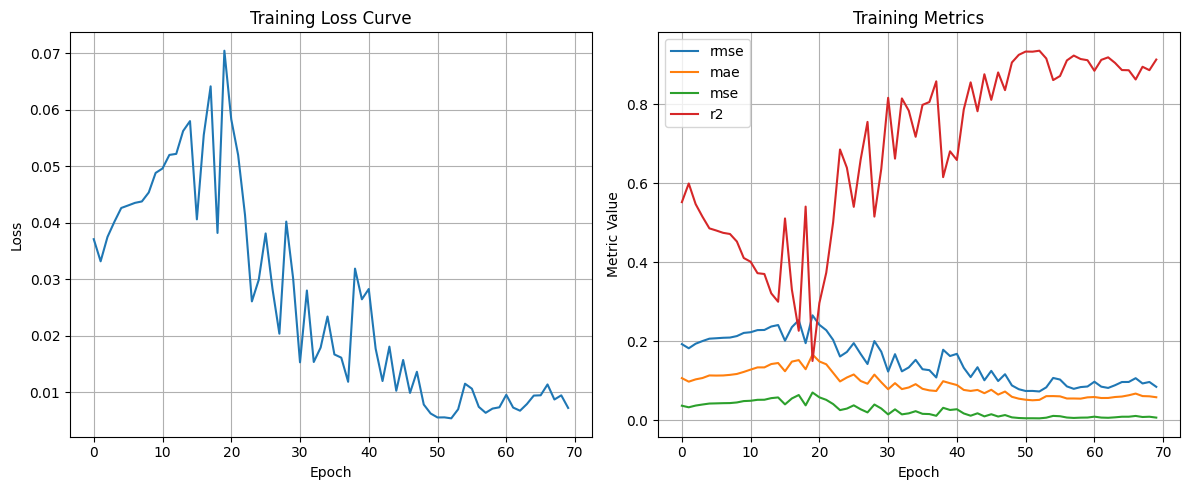

In [25]:
plot_training_history(
    train_results['train_loss'],
    {
        'rmse': train_results['train_rmse'],
        'mae': train_results['train_mae'],
        'mse': train_results['train_mse'],
        'r2': train_results['train_r2'],
    }
)

In [ ]:
len(test_loader)

In [27]:
def test(
    model,
    test_loader,
    device,
):
    model.eval()

    test_preds = []
    test_targets = []

    test_r2 = []
    test_mae = []
    test_mse = []
    test_rmse = []
    # test_eps = []
    

    with torch.no_grad():
        for data, labels in tqdm(test_loader):
            time_frac = torch.linspace(0, 1, steps=labels.shape[0]).unsqueeze(1).to(device)
            data = data.to(device)
            labels = labels.to(device)
            # print(time_frac.shape, "SHAPE X", data.shape)
            predictions = model(data).flatten()
            
            predictions =  torch.cummin(predictions.flip(0), dim=0).values.flip(0)

            test_preds.append(predictions)
            test_targets.append(labels)

        test_preds = torch.cat(test_preds).cpu().detach().numpy()
        test_targets = torch.cat(test_targets).cpu().detach().numpy()

        mse = mean_squared_error(test_targets, test_preds)

        test_r2.append(r2_score(test_targets, test_preds))
        test_mae.append(mean_absolute_error(test_targets, test_preds))
        test_mse.append(mse)
        test_rmse.append(np.sqrt(mse))
        # test_eps.append(early_prediction_score(test_targets, test_preds))

    return {
        'test_r2': test_r2,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_preds': test_preds,
        'test_targets': test_targets,
        # 'test_eps': test_eps,
    }
          

In [42]:
test_results = test(model, test_loader, device)

test_results

100%|██████████| 94/94 [00:00<00:00, 194.15it/s]


{'test_r2': [-13.829308105008513],
 'test_mae': [0.72870284],
 'test_mse': [0.54564095],
 'test_rmse': [0.7386751],
 'test_preds': array([ 0.07621521,  0.07621521,  0.07621521, ..., -0.09083265,
        -0.09083265, -0.09083265], dtype=float32),
 'test_targets': array([[0.9995573 ],
        [0.99933594],
        [0.99911463],
        ...,
        [0.33573863],
        [0.3355173 ],
        [0.33529595]], dtype=float32)}

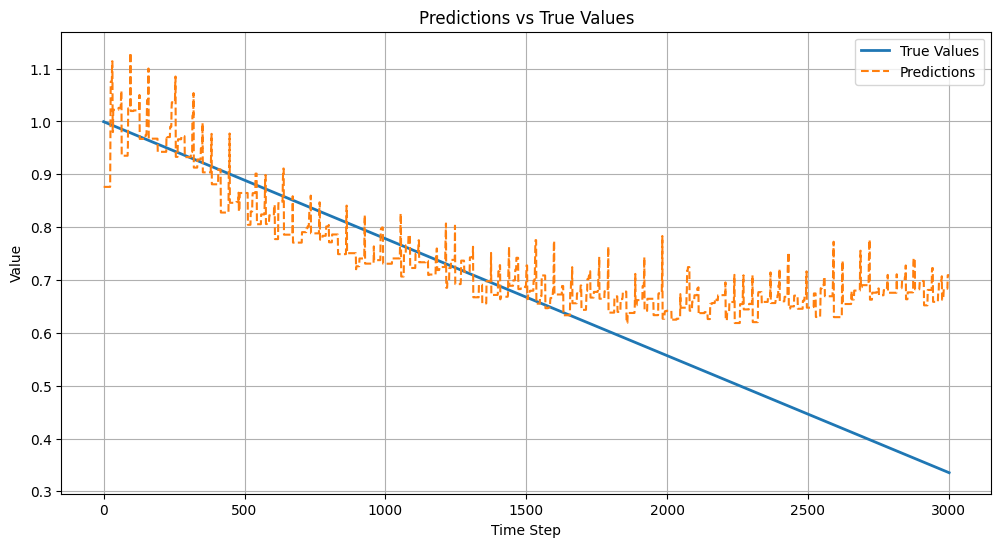

In [44]:
plot_predictions_vs_actuals(
    test_results['test_targets'],
    test_results['test_preds'] + 0.8
)

In [ ]:
test_results['test_targets']

In [ ]:
test_results['test_preds']